![header](../header.png)

# Guia de Processamento Digital de Imagens em linguagem de programação Python

## Estudo de caso em Reconhecimento Automático de Placas Veiculares

### Descrição

Esse guia é composto de diversos notebooks que têm por principal objetivo apresentar o desenvolvimento de algoritmos em linguagem python com uso da biblioteca de visão computacional OpenCV. Para isso, toma como exemplo um estudo de caso em reconhecimento automático de placas veiculares. As imagens utilizadas são do [SSIG-ALPR Database](http://www.smartsenselab.dcc.ufmg.br/ssig-alpr-database).

### Notebook número 11

Esse notebook tem por objetivo utilizar as técnicas aprendidas como método de comparação de imagens. As seguintes formas de comparação serão estudadas:

1. Template Matching
1. Comparação de Histograma

Nesse caso, o primeiro passo a ser dado é a importação das bibliotecas.

In [274]:
import numpy as np
import cv2
from os import listdir, path
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Funcoes uteis 

# Funcao de leitura de imagens
def pdiguide_imgRead(path,convert=True,show=False):
    # Essa funcao cria uma lista de imagens dado o caminho (path) de um diretório.
    # Se "convert" é Verdadeiro, a função irá realizar a conversão das imagens de RGB para Grayscale
    # Se "show" é Verdadeiro, a função irá exibir as imagens carregadas
    
    img = [] # lista de imagens em tons de cinza

    number_of_files = len(listdir(path))#a função listdir forma uma lista com todos os arquivos

    if(show):
        plt.figure(figsize=[15,10]) #define a existencia de uma figura e define o seu tamanho

    #A cada iteração uma imagem é carregada e convertida para tons de cinza, 
    #ao passo que é armazenada nos vetores acima
    for i in range(0,number_of_files): 
        img.append(cv2.imread(path + str(i+1) + '.png'))
        if(convert):
            img[i]=(cv2.cvtColor(img[i],cv2.COLOR_RGB2GRAY))

        #Exibe as imagens
        if(show):
            plt.subplot(1+number_of_files/5,5,i+1)
            plt.imshow(img[i],cmap='gray'),plt.xticks([]),plt.yticks([]) 
            #xticks e yticks controlam as escalas exibidas, nesse caso, serão nulas.
            
    print("Leitura finalizada, total de imagens lidas = ",len(img))
    return img #retorna a lista de imagens
    
# Funcao apenas para exibicao da lista de imagens
def pdiguide_show(list_of_imgs, columns, titles=None):
    # Essa funcao exibe as imagens dado uma lista de imagens.
    number_of_files = len(list_of_imgs)
    for i in range(0,number_of_files): 
        plt.subplot(1+number_of_files/columns,columns,i+1) 
        plt.imshow(list_of_imgs[i],cmap='gray'),plt.xticks([]),plt.yticks([]) 
        if titles != None: plt.title(titles[i])
            
# Funcao para calcular e exibir o histograma de uma imagem 
def pdiguide_histogram(img,nbins,show=False):
    # Essa funcao calcula o histograma de um vetor 2D (imagem grayscale)
    # com valores inteiros entre 0-255.
    # Essa imagem retorna um vetor 1D com o histograma e os pontos 
    # que representam o bin_edges para plotagem do histograma.
    # Caso show seja verdadeiro ela mesmo irá plotar o histograma
    h, bin_edges = np.histogram(img.ravel(), nbins,(0,255))
    if show:
        w=256./nbins
        bin_centers = bin_edges[1:]-(w/2)
        plt.bar(bin_centers, h, width=w)
    
    return h, bin_edges

In [3]:
# Leitura das imagens
path = '../Data/'
img = pdiguide_imgRead(path)

Leitura finalizada, total de imagens lidas =  20


Vamos utilizar um dos algoritmos do [Notebook 10](Notebook10-RepresentacaoDescricao.ipynb) para montar um conjunto de imagem de placas aos quais vamos comparar entre si. Os parâmetros foram reajustados para permitir uma passagem maior de falsas placas.

In [139]:
# Algoritmo do notebook de descrição e representação
def make_plates_images(img):
    '''Cria alguns candidatos a placas'''
    crops = []
    c = 0 
    car_blur = cv2.blur(img,(5,5))
    _,bin_car = cv2.threshold(car_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours,hierarquia = cv2.findContours(bin_car.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(contours, key = cv2.contourArea, reverse = True)[:40]
    for index in range(0,len(cnts)):
        x1,y1,w,h = cv2.boundingRect(cnts[index])
        ar = h/w 
        if(ar >= 0.2 and ar <= 0.5):
            x2 = x1+w
            y2 = y1+h
            crops.append(img.copy()[y1:y2,x1:x2].astype(np.uint8))
    return crops

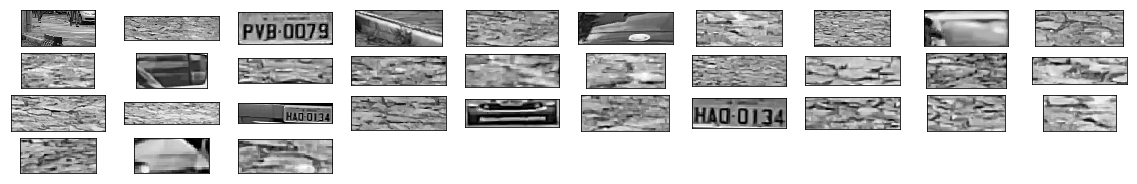

In [293]:
plates2 = []
for i in range(2):
    plates2.append(make_plates_images(img[i]))

plates = []
for plate in plates2:
    for i in range(len(plate)):
        plates.append(plate[i])
    
plt.figure(figsize=(20,3))
for i in range(len(plates)):
    plt.subplot(1+len(plates)/10,10,i+1)
    plt.imshow(plates[i],cmap='gray')
    plt.xticks([])
    plt.yticks([])

####  Comparação de Imagens - Template Matching

Existem diversas técnicas para comparar duas imagens. Para imagens do mesmo tamnho um método simples é o módulo da diferença entre elas, caso queira obter uma medida de dissimilaridade entre as imagens, basta somar os valores dos pixels da matriz de diferença resultante.

Entretanto, no nosso caso estamos considerando imagens com tamanhos distintos. Como então comparar essas imagens? O template matching pode ser útil em situações onde o objeto que intereça possui dimensões similares ao template. Vamos tentar usar o template matching como forma de comparar as imagens e vê o que acontece. Em princípio, utilizaremos como template a imagem da placa da figura 2 (no intervalo de 0 a 19).

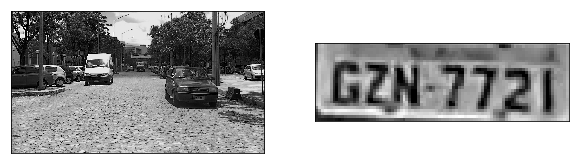

In [168]:
ind = 2
template = img[ind][650:677,1373:1460]
plt.figure(figsize=(10,6))
pdiguide_show([img[ind],template],2)

Vamos definir uma função que gera um score a partir do template matching. Para o score vamos apenas pegar o valor que o próprio template matching usa para localizar a região de maior similaridade ou menor dissimilaridade. Para facilita vamos utilizar somente o método de similaridade do coeficiente de correlação. Entretanto, fique a disposição para testar com outros métodos, lembrando que se o método é de dissimilaridade use o valor mínimo, caso contrário, valor máximo.

In [214]:
# Definicao de uma lista com os metodos usados pelo Template Matching do OpenCV
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR', 
           'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

def template_Match_comparison(image,template):
    
    meth = 'cv2.TM_CCOEFF'
    img2 = image.copy() # copia a imagem original para img2
    method = eval(meth) # associa as strings em métodos as suas contantes do OpenCV
    
    # Aplicando o template Matching
    match = cv2.matchTemplate(img2,template,method) 

    # Extraindo os pontos de máxima e mínimo globais
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(match)
     
    return max_val

De modo a garantir que a imagem template seja sempre menor que a imagem comparada, vamos adicionar um pad de zeros as imagens que forem menores que o template, i.e., vamos adicionar zero a borda das imagens para torná-las maior que o template. Lembre-se porém que isso não é o ideal visto que para um bom template matching o objeto que se procura e a imagem template tem que ter dimensões similares. Em outras palavras o template matching é sensível a escala. Caso queira uma solução diferenciada, busque pos abordagens pirâmidais ou similares.

In [231]:
pad_plates = []
fator_multip = 1
for plate in plates:
    while(plate.shape[0] <= fator_multip*template.shape[0]): # enquanto o número de linhas for menor
        zero_pad_y = np.zeros(plate.shape[1],np.uint8)
        # adicione uma linha de zeros e mesmo tamanho ao final da imagem 
        plate = np.vstack((plate.copy(),zero_pad_y))         
    while(plate.shape[1] <= fator_multip*template.shape[1]): # enquanto o número de coluna for menor
        zero_pad_x = np.zeros([plate.shape[0],1],np.uint8)
        # adicione uma coluna de zeros e mesmo tamanho ao final da imagem
        plate = np.hstack((plate.copy(),zero_pad_x))
    pad_plates.append(plate)

In [232]:
results = []
for plate in pad_plates:
    results.append(template_Match_comparison(plate,template))
print(results)

[714357.375, 321838.65625, 809903.0, 298917.78125, 335685.09375, 440948.5, 193733.09375, 275721.28125, -124564.7734375, 232850.421875, 273063.53125, 230472.15625, 123686.8671875, 182091.421875, 129322.625, 124954.265625, 238811.59375, 302982.96875, 174052.265625, 285378.6875, 383018.34375, 239999.03125, 1603028.625, 331553.28125, 232945.625, 274913.375, 245793.125, 131723.140625, 63095.97265625, 103880.1953125, 147875.640625, -118915.8203125, -72541.9453125]


`Results` é uma lista contendo um score para cada imagem. Vamos agora plotar a imagem que possui o maior score, já que o método usado foi de similaridade.

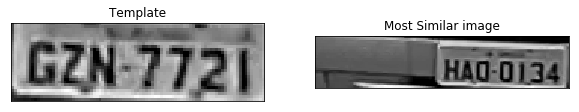

In [233]:
plt.figure(figsize=(10,4))
pdiguide_show([template,pad_plates[np.argmax(results)]],2,['Template','Most Similar image'])

Podemos acreditar que essa imagem foi a melhor selecionada, pois houve um melhor casamento entre o tamanho do template e o tamanho da placa na imagem. Vamos visualizar as três iagens mais similares.

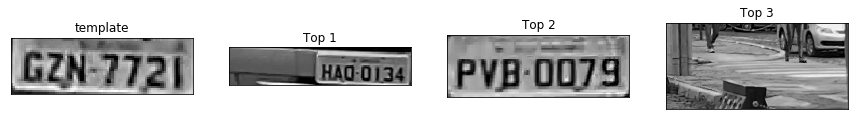

In [247]:
edit_results = results.copy()
top = 3
to_plot = []
to_plot.append(template)
titles = []
titles.append('template')

for i in range(top):
    to_plot.append(pad_plates[np.argmax(edit_results)])
    edit_results[np.argmax(edit_results)] = 0
    titles.append('Top '+str(i+1))

plt.figure(figsize=(15,4))
pdiguide_show(to_plot,top+1,titles)

Observa-se que as duas primeiras imagens realmente condizem a placas, a partir da terceira, o algoritmo já se comporta de forma diferente.

#### Comparação de Imagens - Comparação de Histogramas

A comparação de histogramas é uma abordagem para determinar similaridades e dissimilaridades entre os valores dos pixels de duas imagens. Entretanto, por se tratar de histograma não considera a distribuição espacial dos pixels. Vamos fazer alguns testes com essa abordagem.

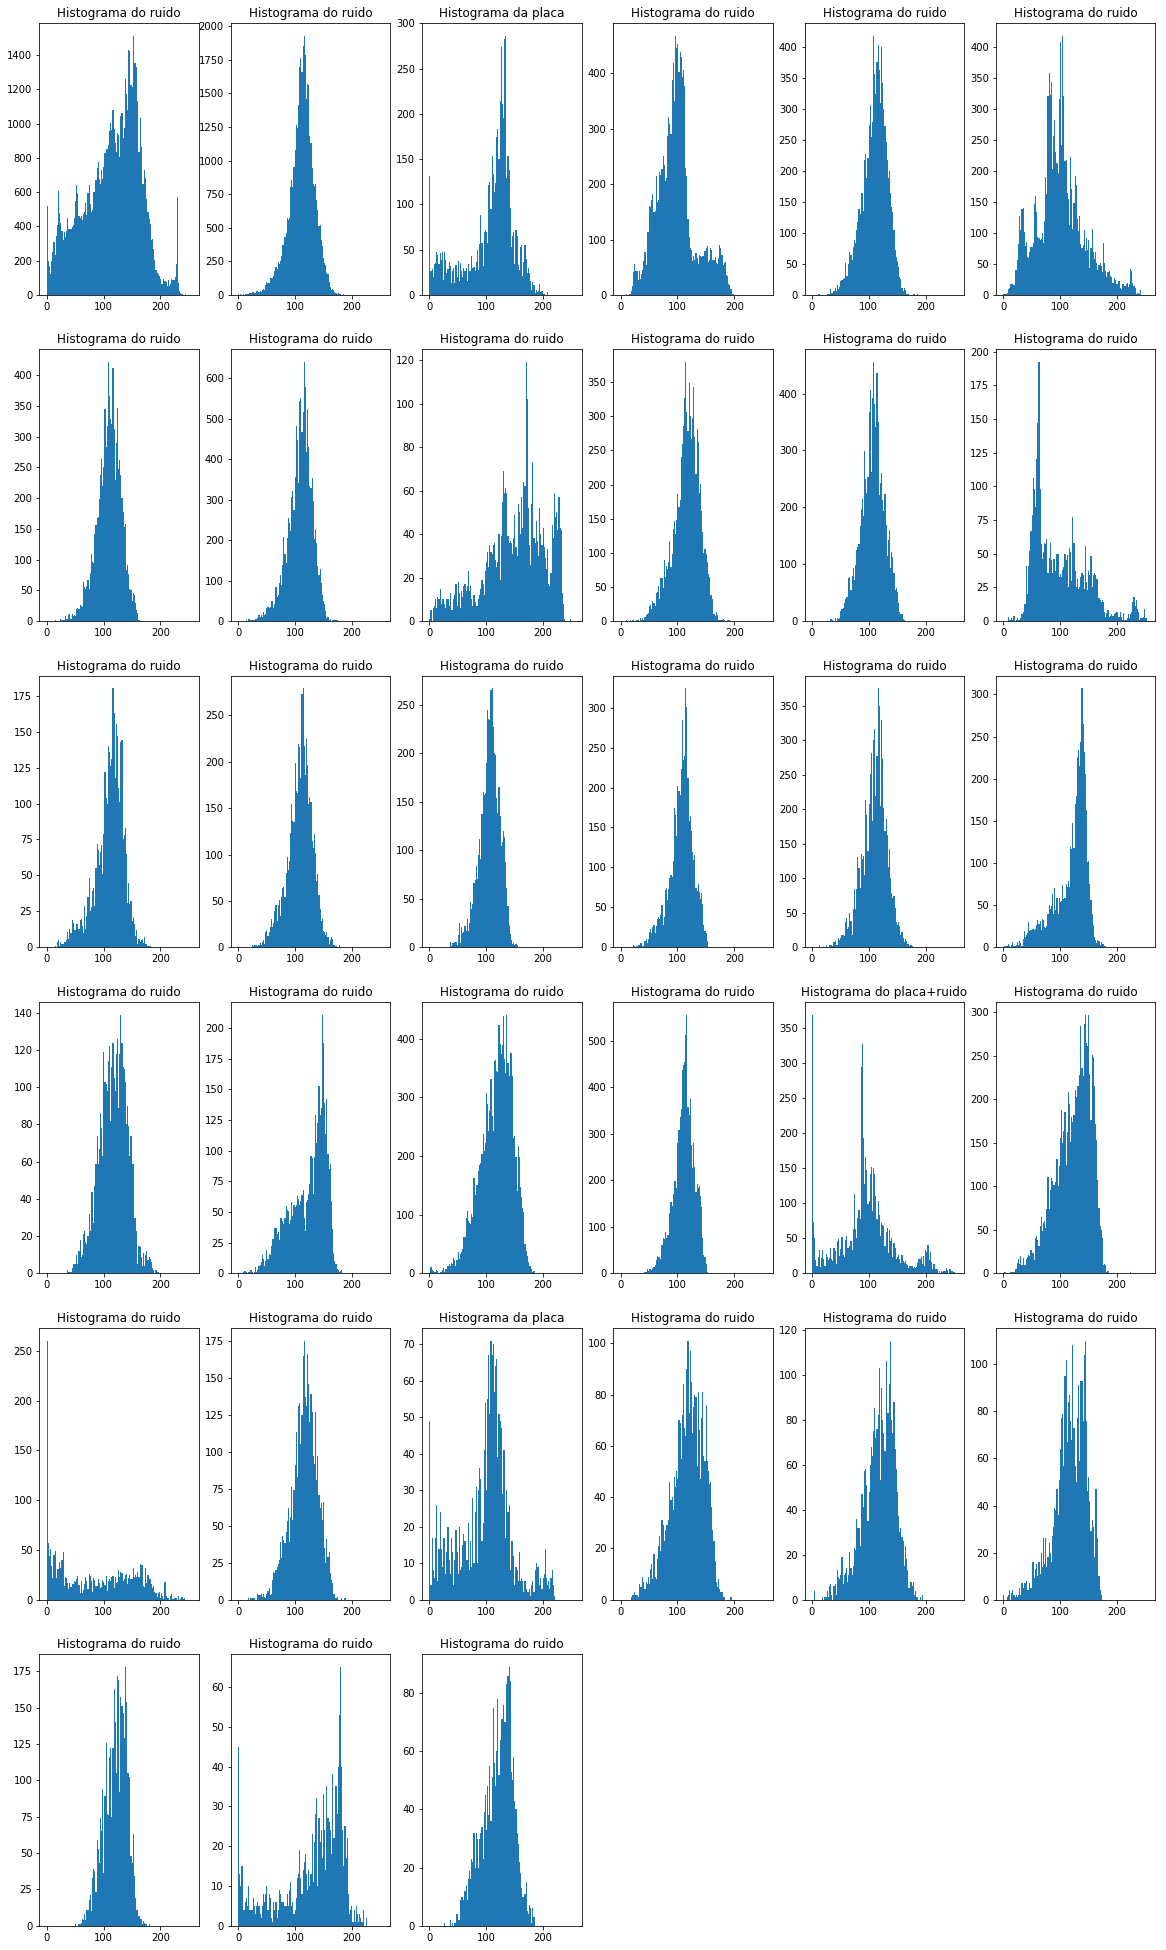

In [334]:
nbins = 128
s = len(plates)
hists = []
plt.figure(figsize=(20,35))
for i in range(s):
    plt.subplot(s/6+1,6,i+1)
    #eq = cv2.equalizeHist(plates[i])
    h,_ = pdiguide_histogram(plates[i],nbins,show=True)
    if(i == 2 or i == 26): 
        plt.title('Histograma da placa')
    elif(i == 22):
        plt.title('Histograma do placa+ruido')
    else:
        plt.title('Histograma do ruido')
    hists.append(h)

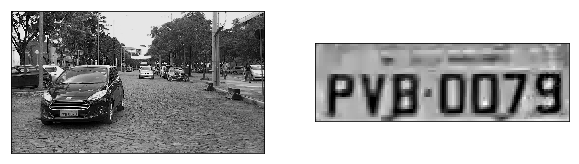

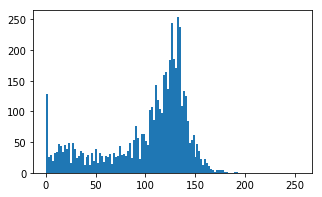

In [335]:
ind = 0
template = img[ind][760:800,370:500]
plt.figure(figsize=(10,6))
pdiguide_show([img[ind],template],2)

# Calculando e adequando o histograma do template
#eq_template = cv2.equalizeHist(template)
plt.figure(figsize=(5,3))
h_temp,_ = pdiguide_histogram(template,nbins,show=True)
hist_template = h_temp.ravel().astype('float32')

In [336]:
# Metodos de similaridade e dissimilaridade do OpenCV para comparação de histogramas
methods = ['cv2.HISTCMP_CORREL','cv2.HISTCMP_CHISQR','cv2.HISTCMP_INTERSECT',
           'cv2.HISTCMP_BHATTACHARYYA', 'cv2.HISTCMP_CHISQR_ALT', 'cv2.HISTCMP_KL_DIV']

# Declarando dicionário de comparação
comparison={}

for compare_method in methods:
    scores = []
    for h in hists:
        value = cv2.compareHist(hist_template, h.ravel().astype('float32'), eval(compare_method))
        scores.append(value)
    comparison[compare_method] = scores

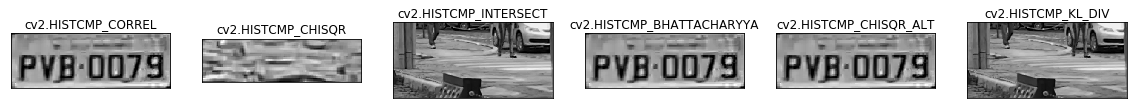

In [337]:
img_chosen = []
for compare_method in methods:
    if compare_method == 'cv2.HISTCMP_CORREL' or compare_method == 'cv2.HISTCMP_INTERSECT' :
        index = np.argmax(comparison[compare_method])
    else:
        index = np.argmin(comparison[compare_method])
    img_chosen.append(plates[index])

plt.figure(figsize=(20,4))
pdiguide_show(img_chosen,ft,methods)

O objetivo principal com esse notebook era mostrar formas de comparar imagem e introduzir conceitos como similaridade e dissimilaridade. Além desses métodos existem outras formas de comparar imagens. 

Observe que tentamos reconhecer, ou classificar se uma imagem é de placa ou não. Para isso levamos em consideração a imagem de uma placa. Outras abordagens poderiam ser exploradas para esse problemas de classificar se é placa ou não, como exemplo: 

- uso de técnicas de componentes conexos ou segmentação por região para tentar identificar caracteres na placa
- uso de contornos para detectar a região retangular da placa ou ainda identificar os caracteres
- de forma semelhante, uso da transformada de Hough para detectar caracteres e retângulos
- traçar uma espécie de histograma cujo eixo x seja a coluna da imagem e o eixo y o valor do pixel na linha central da imagem. A ideia é observar a existência de transições entre a placa e o caractere.
- entre outras formas, fica abertos para descobri-las e/ou inventá-las.


### Referências
